In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [7]:
gas = pd.read_csv('D:/download/Nat_Gas.csv')

In [8]:
gas = pd.DataFrame(gas)
gas['Dates'] = pd.to_datetime(gas['Dates'])
gas = gas.set_index('Dates')
gas

C:\Users\focus\AppData\Local\Temp\ipykernel_10480\1313616370.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  gas['Dates'] = pd.to_datetime(gas['Dates'])


,Prices
Dates,
2020-10-31,10.10
2020-11-30,10.30
2020-12-31,11.00
2021-01-31,10.90
2021-02-28,10.90
2021-03-31,10.90
2021-04-30,10.40
2021-05-31,9.84
2021-06-30,10.00


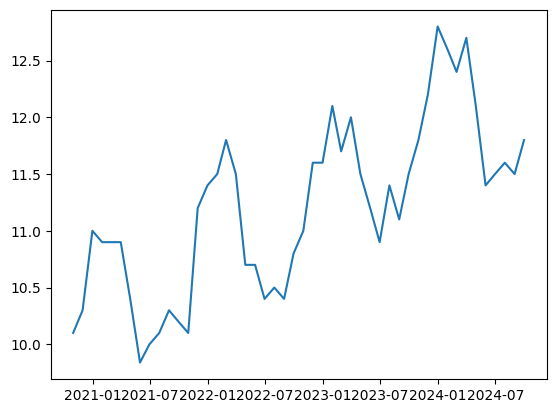

In [9]:
#1. load and visualize the data
plt.plot(gas)

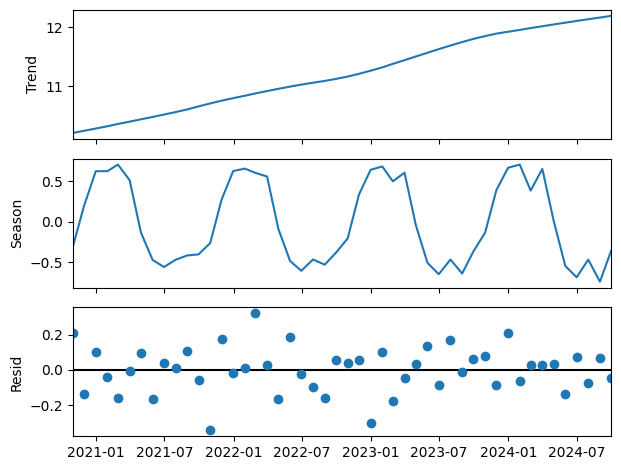

In [5]:
#2. decompose using stl
stl = STL(gas['Prices'],seasonal=13)
#The STL implementation in statsmodels requires the seasonal parameter to be an odd integer greater than or equal to 3. This is a specific requirement for the LOESS-based decomposition method.In most cases, for monthly data, we'd expect a seasonality of 12. However, since STL requires it to be odd, thus seasonal = 13

result = stl.fit()

fig = result.plot(observed=False, resid=True)
plt.show()

In [6]:
#1. Trend: This represents the underlying trend in the data.
#2. Seasonal: This captures the recurring patterns or cycles. In our synthetic data, this is a sinusoidal pattern.
#3. Residual: This is the noise or the irregular component left after extracting trend and seasonality.

In [7]:
gas.index.freq = 'M'

In [8]:
trend = ARIMA(result.trend.dropna(), order=(1,1,1))
trendFit = trend.fit()
forecastPeriods = 12
trendForecast = trendFit.forecast(steps = forecastPeriods)

In [9]:
#ARMA for stationary time series, ARIMA is good for non-stationary time series: The "I" in ARIMA stands for "integrated" and refers to the number of differences applied to transform the series into a stationary one. Stationarity is a requirement for many time series forecasting methods. AR(auto regressive) MA(moving average)
#ARIMA(1,1,1) order as a commonly used starting point for many time series, especially when there's no pronounced seasonality or when the seasonality has been removed or adjusted for. In practice, model selection should involve a more rigorous process:

#1. Examine the ACF and PACF plots.
#2. Fit multiple models with different orders.
#3. Compare the models using criteria like the Akaike Information Criterion (AIC) or the Bayesian Information Criterion (BIC).
#4. Validate the chosen model using out-of-sample predictions, if possible.

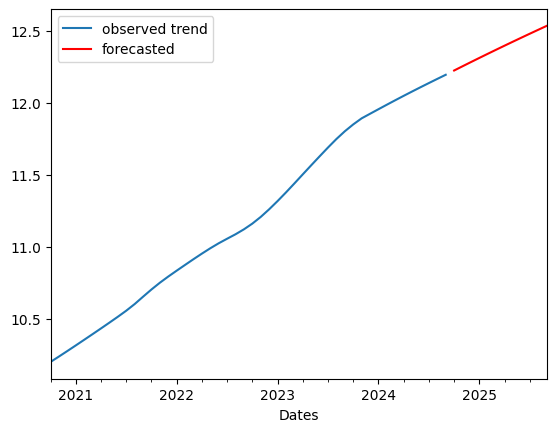

In [10]:
result.trend.plot(label = 'observed trend')
trendForecast.plot(label = 'forecasted', color = 'red')

plt.legend()
plt.show()

In [11]:
#4. forecast
#a) Model and forecast the residuals using ARIMA.
#b) Combine the forecasted trend, known seasonality, and forecasted residuals to obtain the final forecast.

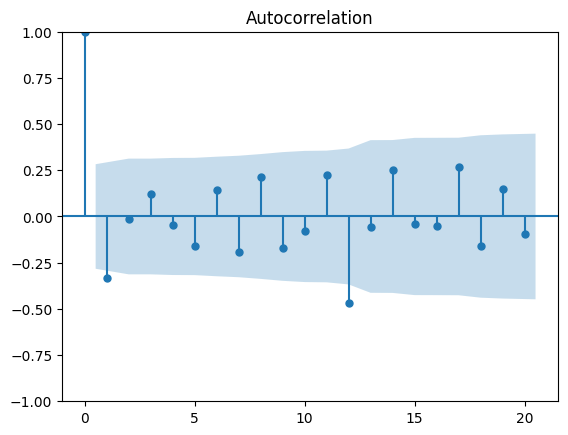

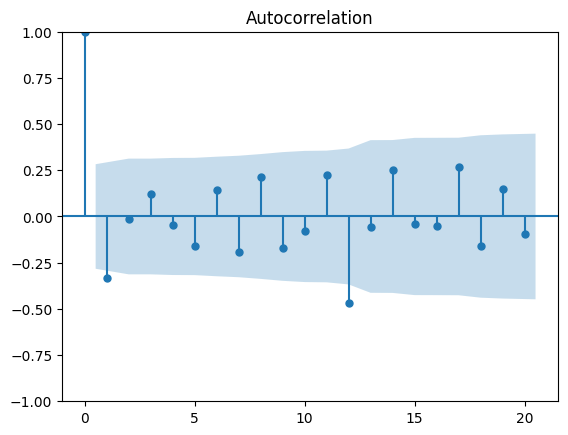

In [12]:
plot_acf(result.resid.dropna(), lags=20)

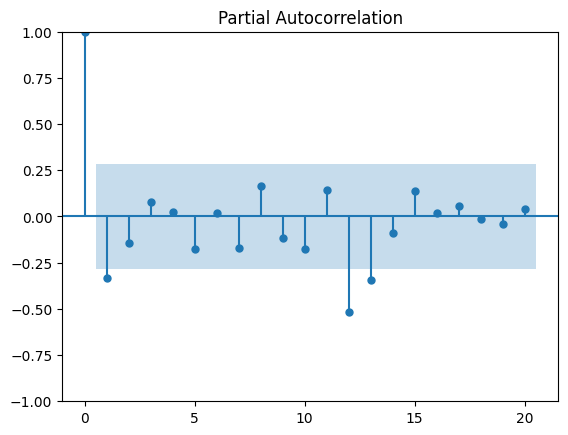

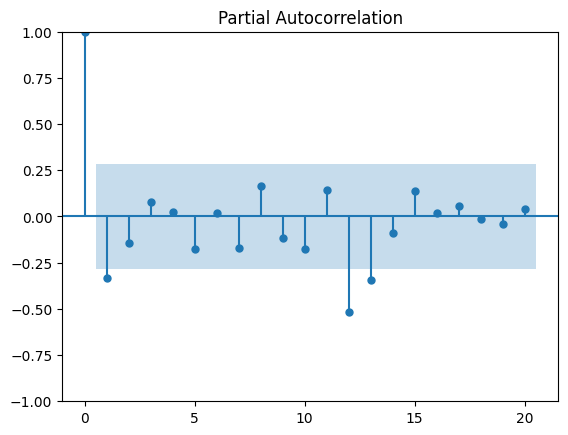

In [13]:
plot_pacf(result.resid.dropna(), lags=20)

In [14]:
# Model and forecast the residuals
resModel = ARIMA(result.resid.dropna(), order=(1,1,2))
resFit = resModel.fit()
resForecast = resFit.forecast(steps = forecastPeriods)

In [15]:
forecast_index = pd.date_range(start=gas.index[-1] + pd.Timedelta(days=30), periods=forecastPeriods, freq='M' )

trendForecast.index = forecast_index
resForecast.index = forecast_index
seasonalForecast = result.seasonal.tail(forecastPeriods)
seasonalForecast.index = forecast_index

# combine the forecasted trend, known seasonality and forecasted residuals
forecastTol = trendForecast + seasonalForecast + resForecast

In [16]:
{
    'trendForecast': trendForecast.values,
    'seasonality': result.seasonal.tail(forecastPeriods).values,
    'resForecast': resForecast.values, 
    'final': forecastTol.values
}

{'trendForecast': array([12.22584397, 12.25522537, 12.28435435, 12.31323306, 12.34186367,
        12.37024829, 12.39838905, 12.42628805, 12.45394734, 12.48136901,
        12.50855508, 12.53550759]),
 'seasonality': array([-0.13295403,  0.39039564,  0.66530816,  0.70422968,  0.38503784,
         0.65104295,  0.0142226 , -0.54231807, -0.68236394, -0.4649035 ,
        -0.73629006, -0.35155912]),
 'resForecast': array([ 0.01245969, -0.00150215,  0.00060517,  0.0002871 ,  0.00033511,
         0.00032786,  0.00032895,  0.00032879,  0.00032881,  0.00032881,
         0.00032881,  0.00032881]),
 'final': array([12.10534962, 12.64411886, 12.95026767, 13.01774984, 12.72723662,
        13.0216191 , 12.4129406 , 11.88429877, 11.77191222, 12.01679432,
        11.77259384, 12.18427728])}

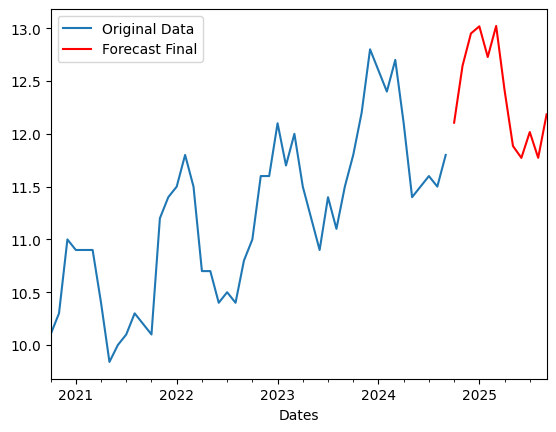

In [17]:

#plot
gas['Prices'].plot(label = 'Original Data')
forecastTol.plot(label = 'Forecast Final', color = 'red')

plt.legend()
plt.show()

In [18]:
forecastTol.index

DatetimeIndex(['2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31', '2025-04-30', '2025-05-31',
               '2025-06-30', '2025-07-31', '2025-08-31', '2025-09-30'],
              dtype='datetime64[ns]', freq='M')

In [23]:
def forecastedPrice(date_string):
    try:
        date_obj = pd.to_datetime(date_string)
        
        if date_obj in forecastTol.index:
            return forecastTol[date_obj]
        else:
            return f'{date_string} out of forecasted range'
    except Exception as e:
        return f'Error: {e}'

In [31]:
test = '2024-10-31'
forecastedPrice(test)

12.105349624235986

In [32]:
test2 = '2025-01-31'
forecastedPrice(test2)

13.01774983628908

Injection dates. 
Withdrawal dates.
The prices at which the commodity can be purchased/sold on those dates.
The rate at which the gas can be injected/withdrawn.
The maximum volume that can be stored.
Storage costs.

In [33]:
def contractPrice(injD, wdrlD, pricesIW, rate, maxVol, storageCosts,amt):
    injDate = pd.Timestamp(injD)
    wdrlDate = pd.Timestamp(wdrlD)
    months = (wdrlDate.year - injDate.year) * 12 + wdrlDate.month - injDate.month
    injP = forecastedPrice(injDate)
    wdrlP = forecastedPrice(wdrlDate)
    if amt <= maxVol:
        value = (wdrlP - injP) * amt - rate * amt / 1000000 - storageCosts * months - pricesIW * 2
        return value
    else:
        return "max Volume exceeded"
    
    

In [35]:
injD = '2024-10-31'
wdrlD = '2025-01-31'
pricesIW = 50000
rate = 10000
maxVol = 10000000
storageCosts = 100000
amt = 1000000

contractPrice(injD, wdrlD, pricesIW, rate, maxVol, storageCosts,amt)

502400.2120530931

In [12]:
import os

cwd = os.getcwd()

print("Current working directory: {0}".format(cwd))

print ("os.getcwd() returns an object of type {0}".format(type(cwd)))


Current working directory: d:\python project pycharm\venv
os.getcwd() returns an object of type <class 'str'>


In [14]:

# copy the filepath 
os.chdir ("D:/download")

# let's jump into task 1


C:\Users\focus\AppData\Local\Temp\ipykernel_10480\44489025.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date_time = pd.to_datetime(date_time)
C:\Users\focus\AppData\Local\Temp\ipykernel_10480\44489025.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('D:/download/Nat_Gas.csv', parse_dates=['Dates'])


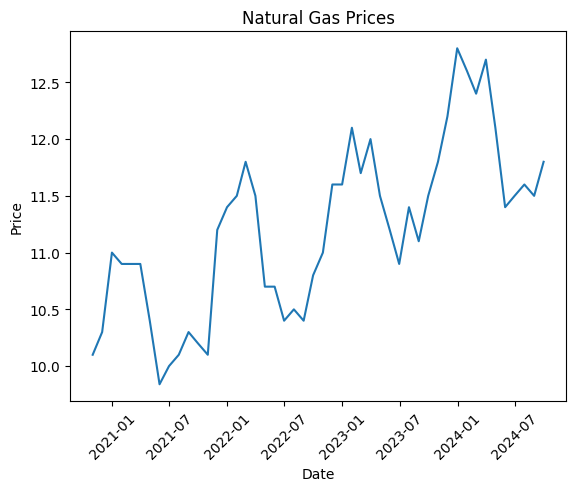

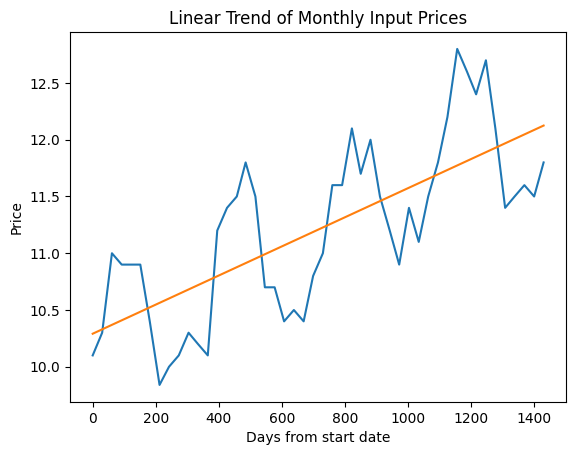

0.001282373598760221 10.29104112595228


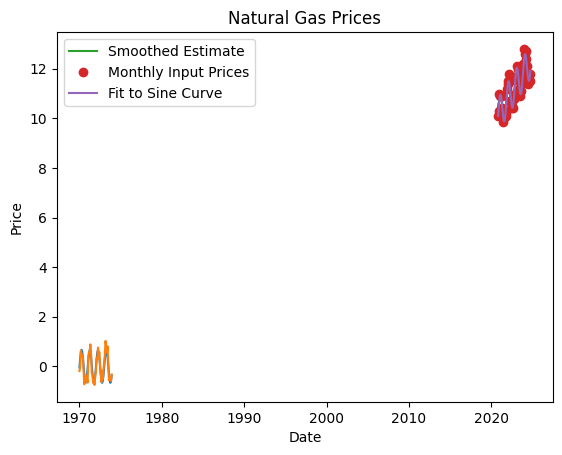

In [16]:

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import date, timedelta

date_time = ["10-2020", "11-2020", "12-2020"]
date_time = pd.to_datetime(date_time)
data = [1, 2, 3]

df = pd.read_csv('D:/download/Nat_Gas.csv', parse_dates=['Dates'])
prices = df['Prices'].values
dates = df['Dates'].values

# plot prices against dates
fig, ax = plt.subplots()
ax.plot_date(dates, prices, '-')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Natural Gas Prices')
ax.tick_params(axis='x', rotation=45)

plt.show()

# From the plot - we can see the prices have a natural frequency of around a year, but trend upwards. 
# We can do a linear regression to get the trend, and then fit a sin function to the variation in each year.

# First we need the dates in terms of days from the start, to make it easier to interpolate later.
start_date = date(2020,10,31)
end_date = date(2024,9,30)
months = []
year = start_date.year
month = start_date.month + 1
while True:
    current = date(year, month, 1) + timedelta(days=-1)
    months.append(current)
    if current.month == end_date.month and current.year == end_date.year:
        break
    else:
        month = ((month + 1) % 12) or 12
        if month == 1:
            year += 1
        
days_from_start = [(day - start_date ).days for day in months]

# Simple regression for the trend will fit to a model y = Ax + B. The estimator for the slope is given by \hat{A} = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sum (x_i - \bar{x})^2}, 
# and that for the intercept by \hat{B} = \bar{y} - hat{A} * \xbar

def simple_regression(x, y):
    xbar = np.mean(x)
    ybar = np.mean(y)
    slope = np.sum((x - xbar) * (y - ybar))/ np.sum((x - xbar)**2)
    intercept = ybar - slope*xbar
    return slope, intercept

time = np.array(days_from_start)
slope, intercept = simple_regression(time, prices)

# Plot linear trend
plt.plot(time, prices)
plt.plot(time, time * slope + intercept)
plt.xlabel('Days from start date')
plt.ylabel('Price')
plt.title('Linear Trend of Monthly Input Prices')
plt.show()
print(slope, intercept)


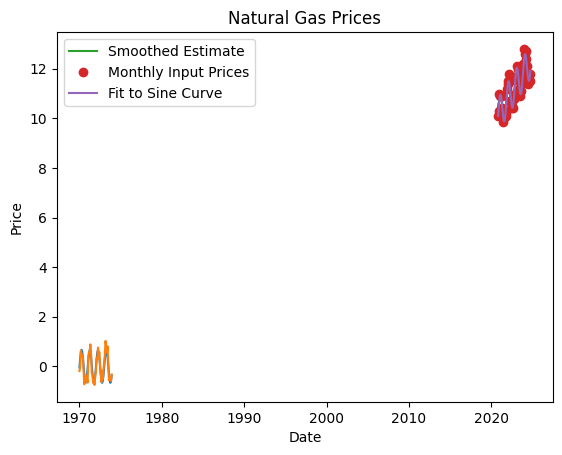

In [17]:

# From this plot we see the linear trend has been captured. Now to fit the intra-year variation. 
# Given that natural gas is used more in winter, and less in summer, we can guess the frequency of the price movements to be about a year, or 12 months.
# Therefore we have a model y = Asin( kt + z ) with a known frequency.Rewriting y = Acos(z)sin(kt) + Asin(z)cos(kt), 
# we can use bilinear regression, with no intercept, to solve for u = Acos(z), w = Asin(z)

sin_prices = prices - (time * slope + intercept)
sin_time = np.sin(time * 2 * np.pi / (365))
cos_time = np.cos(time * 2 * np.pi / (365))

def bilinear_regression(y, x1, x2):
    # Bilinear regression without an intercept amounts to projection onto the x-vectors
    slope1 = np.sum(y * x1) / np.sum(x1 ** 2)
    slope2 = np.sum(y * x2) / np.sum(x2 ** 2)
    return(slope1, slope2)

slope1, slope2 = bilinear_regression(sin_prices, sin_time, cos_time)

# We now recover the original amplitude and phase shift as A = slope1 ** 2 + slope2 ** 2, z = tan^{-1}(slope2/slope1)
amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
shift = np.arctan2(slope2, slope1)

# Plot smoothed estimate of full dataset
plt.plot(time, amplitude * np.sin(time * 2 * np.pi / 365 + shift))
plt.plot(time, sin_prices)
plt.title('Smoothed Estimate of Monthly Input Prices')


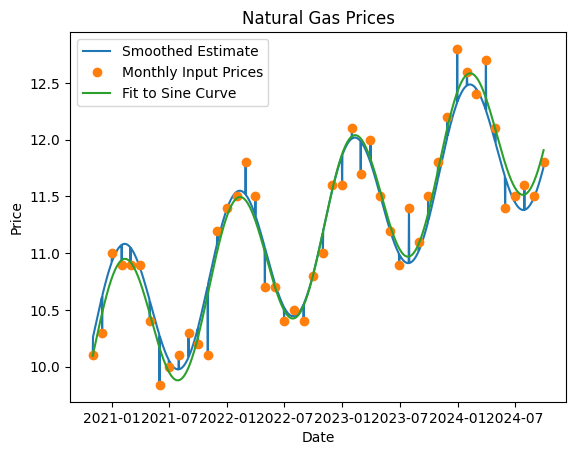

In [18]:

# Define the interpolation/extrapolation function
def interpolate(date):
    days = (date - pd.Timestamp(start_date)).days
    if days in days_from_start:
        # Exact match found in the data
        return prices[days_from_start.index(days)]
    else:
        # Interpolate/extrapolate using the sin/cos model
        return amplitude * np.sin(days * 2 * np.pi / 365 + shift) + days * slope + intercept

# Create a range of continuous dates from start date to end date
continuous_dates = pd.date_range(start=pd.Timestamp(start_date), end=pd.Timestamp(end_date), freq='D')

# Plot the smoothed estimate of the full dataset using interpolation
plt.plot(continuous_dates, [interpolate(date) for date in continuous_dates], label='Smoothed Estimate')


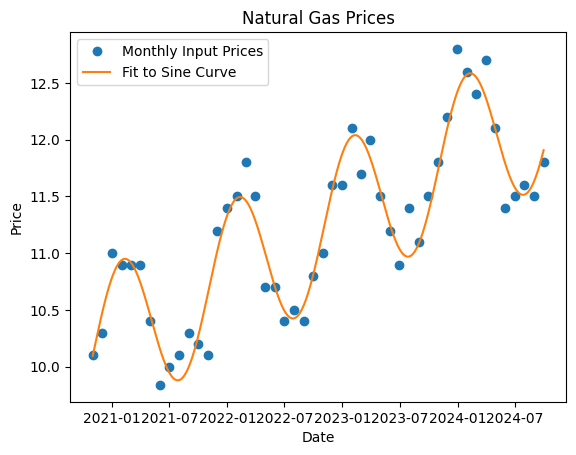

In [19]:

# Fit the monthly input prices to the sine curve
x = np.array(days_from_start)
y = np.array(prices)
fit_amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
fit_shift = np.arctan2(slope2, slope1)
fit_slope, fit_intercept = simple_regression(x, y - fit_amplitude * np.sin(x * 2 * np.pi / 365 + fit_shift))
plt.plot(dates, y, 'o', label='Monthly Input Prices')
plt.plot(continuous_dates, fit_amplitude * np.sin((continuous_dates - pd.Timestamp(start_date)).days * 2 * np.pi / 365 + fit_shift) + (continuous_dates - pd.Timestamp(start_date)).days * fit_slope + fit_intercept, label='Fit to Sine Curve')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Natural Gas Prices')
plt.legend()
plt.show()
